# Teranet dataset
# Exploratory Spatial Data Analysis (ESDA)
# Alpha-shapes
This notebook describes the process of generating [alpha shapes](https://en.wikipedia.org/wiki/Alpha_shape) from Teranet records.  


## Summary of the previous steps
Teranet records previously were: 
* cleaned and filtered for duplicates
    * `consideration_amt` < $30 were reset to NaN (Not a Number, missing values)
    * records matching on all columns have been removed (83'798 records)
    * records matching on all columns excluding `pin` have been removed (729'182 records)
    * **813'138 duplicate entries** removed in total from original Teranet dataset 
    * 8'226'103 unique records remain after duplicates have been removed
    * see notebook `data_cleaning/Teranet_data_cleaning.ipynb` for details

* filtered to include only records from GTHA 
    * filtering performed via a spatial join
    * `xy` coordinates of Teranet records joined (how='inner', op='within') with DA geometry for GTHA 
    * DA geometry provided by York Municipal Government (accessed via Esri Open Data portal)
    * 6,062,853 records have `xy` coordinates within GTHA boundary
    * see notebook `data_cleaning/Teranet_GTHA_DA_spatial_join.ipynb` for details

## Alpha shapes
From [wikipedia](https://en.wikipedia.org/wiki/Alpha_shape):  
In computational geometry, an alpha shape, or α-shape, is a family of piecewise linear simple curves in the Euclidean plane associated with the shape of a finite set of points. They were first defined by [Edelsbrunner, Kirkpatrick & Seidel (1983)](https://ieeexplore.ieee.org/document/1056714). The alpha-shape associated with a set of points is a generalization of the concept of the convex hull, i.e. every convex hull is an alpha-shape but not every alpha shape is a convex hull.

<img src='img/alpha_shapes.png'>

In this notebook, alpha shapes (polygons) will be generated from Teranet point data using PySal library in Python.

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns
from pysal.lib.cg import alpha_shape_auto
import contextily as ctx
import os
import sys
import time

In [3]:
os.chdir('Documents/repos/geo')
os.listdir()

['.git',
 '.gitattributes',
 '.gitignore',
 '.idea',
 '.ipynb_checkpoints',
 'data',
 'downloads',
 'img',
 'notebooks',
 'presentations',
 'README.md',
 'src',
 '__pycache__']

In [4]:
sys.path.append('src')

In [6]:
dtypes = {
    'decade': 'int',
    'year': 'int',
    'lro_num': 'category',
    'pin': 'category',
    'postal_code': 'category',
    'street_designation': 'category',
    'street_direction': 'category',
    'municipality': 'category',
    'da_id': 'category',
    'xy': 'category'
}
t = time.time()
teranet_path = 'data/HHSaleHistory_cleaned_v0.9_GTHA_DA_with_cols_v0.9.csv'
df = pd.read_csv(teranet_path,
                 dtype=dtypes,
                 parse_dates=['registration_date'])\
        .set_index('registration_date').sort_index()
elapsed = time.time() - t
print("----- DataFrame with Teranet records loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame with Teranet records loaded
in 68.14 seconds
with 4,637,584 rows
and 37 columns
-- Column names:
 Index(['decade', 'year', 'lro_num', 'pin', 'consideration_amt', 'postal_code',
       'unitno', 'street_name', 'street_designation', 'street_direction',
       'municipality', 'street_number', 'x', 'y', 'da_id', 'da_city',
       'da_median_tot_inc', 'xy', 'pin_total_sales', 'xy_total_sales',
       'pin_prev_sales', 'xy_prev_sales', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'da_days_since_last_sale',
       'da_years_since_last_sale', 'pin_sale_next_6m', 'pin_sale_next_1y',
       'pin_sale_next_3y', 'xy_sale_next_6m', 'xy_sale_next_1y',
       'xy_sale_next_3y'],
      dtype='object')


In [38]:
colors = sns.color_palette('Set1', n_colors=25, desat=.5)

In [20]:
start = '1960-01-01'
stop = str(int(start[:4]) + 1) + '-01-01'
s = df.loc[start:stop]
print("{0} points in the subset from {1} to {2}."
      .format(len(s), 
              s.index.min(),
              s.index.max()))
muns = s.groupby('da_city')[['x', 'y']]\
    .apply(lambda tab: alpha_shape_auto(tab.values))
mun_counts = s.groupby('da_city')['x'].count()
muns = gpd.GeoDataFrame({'geometry': muns}, crs='+init=epsg:4326') 
f, ax = plt.subplots(1, figsize=(12, 12))
muns.reset_index().to_crs(epsg=3857)\
    .plot(column='da_city', legend=True, 
          legend_kwds={'loc': 'lower right'}, ax=ax)
for idx, mun in muns.iterrows():
    mun_centroid = mun['geometry'].centroid
    ax.text(mun_centroid.x, mun_centroid.y, idx)
            #+ '\n' + 
#            str(mun_counts[idx]) + " records")
ax.set_title("Alpha shapes of each GTHA municipality"
             "based on Teranet records from {0} to {1}"
             .format(start,
                     stop))
ctx.add_basemap(ax=ax, url=ctx.sources.ST_TONER_HYBRID, 
                alpha=0.5)
plt.show()

811 points in the subset from 1960-01-04 00:00:00 to 1960-12-30 00:00:00.


In [34]:
muns.reset_index()

,da_city,geometry
0,Ajax,"POLYGON ((-79.0234402217708 43.8565642295148, ..."
1,Brampton,"POLYGON ((-79.7788995101393 43.6935509935715, ..."
2,Brock,"POLYGON ((-79.1469171147142 44.4830699212916, ..."
3,Burlington,POLYGON ((-79.88910646726521 43.43988214626951...
4,Caledon,"POLYGON ((-79.81231620157079 43.7513276790644,..."
5,Clarington,"POLYGON ((-78.5326872428508 44.028979619574, -..."
6,East Gwillimbury,"POLYGON ((-79.3092333197862 44.13197308831389,..."
7,Georgina,"POLYGON ((-79.4890838261295 44.25508239040889,..."
8,Halton Hills,"POLYGON ((-80.0498227629441 43.6287332674565, ..."
9,Hamilton,"POLYGON ((-79.71889195820391 43.1546859640265,..."


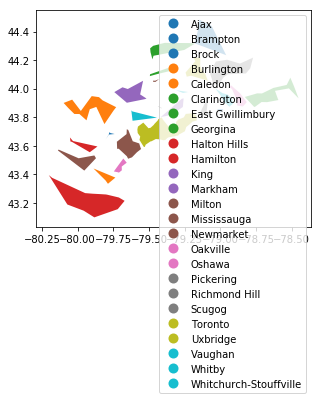

In [31]:
muns.index

Index(['Ajax', 'Brampton', 'Brock', 'Burlington', 'Caledon', 'Clarington',
       'East Gwillimbury', 'Georgina', 'Halton Hills', 'Hamilton', 'King',
       'Markham', 'Milton', 'Mississauga', 'Newmarket', 'Oakville', 'Oshawa',
       'Pickering', 'Richmond Hill', 'Scugog', 'Toronto', 'Uxbridge',
       'Vaughan', 'Whitby', 'Whitchurch-Stouffville'],
      dtype='object', name='da_city')

In [ ]:
alpha_gdf = gpd.GeoDataFrame({'geometry': [poly]}, crs='+init=epsg:4326')
